In [164]:
import pandas as pd
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
import numpy as np
import random
import nltk
import json
import os
import yellowbrick
import glob

from pos_viz import PosTagVisualizer

#nltk.download("averaged_perceptron_tagger")
#nltk.download("tagsets")

random.seed(52)

%matplotlib inline

In [384]:
root_path = '/Users/youssefbrachmi/Desktop/Projets/COVID-19/Risk factors/CORD-19-research-challenge/'

metadata_path = f'{root_path}/metadata.csv'
meta_df = pd.read_csv(metadata_path, dtype={
    'pubmed_id': str,
    'Microsoft Academic Paper ID': str, 
    'doi': str
})

all_json = glob.glob(f'{root_path}/**/pdf_json/*.json', recursive = True)
len(all_json)

48410

In [385]:
risk_uid = pd.read_csv(f'{root_path}/risk_uid.csv')
liste_relevant = list(risk_uid['cord_uid'])

In [386]:
# définir une classe pour lire les fichiers Json

class FileReader:
    def __init__(self, file_path):
        with open(file_path) as file:
            content = json.load(file)
            self.paper_id = content['paper_id']
            self.abstract = []
            self.body_text = []
            # Abstract
            for entry in content['abstract']:
                self.abstract.append(entry['text'])
            # Body text
            for entry in content['body_text']:
                self.body_text.append(entry['text'])
            self.abstract = '\n'.join(self.abstract)
            self.body_text = '\n'.join(self.body_text)
    def __repr__(self):
        return f'{self.paper_id}: {self.abstract[:200]}... {self.body_text[:200]}...'
    
first_row = FileReader(all_json[0])
print(first_row)

86d4262de73cf81b5ea6aafb91630853248bff5f: The endoplasmic reticulum (ER) is the biggest organelle in most cell types, but its characterization as an organelle with a continuous membrane belies the fact that the ER is actually an assembly of s... The endoplasmic reticulum (ER) is a multi-functional organelle that distinguishes itself from other organelles by its size and the plethora of functions associated with it. The size of this organelle ...


In [387]:
def get_breaks(content, length):
    data = ""
    words = content.split(' ')
    total_chars = 0

    # add break every length characters
    for i in range(len(words)):
        total_chars += len(words[i])
        if total_chars > length:
            data = data + "<br>" + words[i]
            total_chars = 0
        else:
            data = data + " " + words[i]
    return data

In [69]:
###################
"""
# Cellule à copier pour code Abdelmalek
dict_ = {'cord_uid':[], 'paper_id': [], 'body_text': []}
for idx, entry in enumerate(all_json):
    if idx % (len(all_json) // 10) == 0:
        print(f'Processing index: {idx} of {len(all_json)}')
    
    try:
        content = FileReader(entry)
    except Exception as e:
        continue  # invalid paper format, skip
    
    # get metadata information
    meta_data = meta_df.loc[meta_df['sha'] == content.paper_id]
    # no metadata, skip this paper
    if len(meta_data) == 0:
        continue
    
    dict_['paper_id'].append(content.paper_id)
    dict_['body_text'].append(content.body_text)
    
    # get metadata information
    meta_data = meta_df.loc[meta_df['sha'] == content.paper_id]
    
    # add doi and cord_uid
    dict_['cord_uid'].append(meta_data['cord_uid'].values[0])
    
df_covid = pd.DataFrame(dict_, columns = ['cord_uid','paper_id', 'body_text'])
risk_paper_df = pd.merge(risk_paper_df, df_covid, on = 'cord_uid', how = 'left')
"""
###################

"\n# Cellule à copier pour code Abdelmalek\ndict_ = {'cord_uid':[], 'paper_id': [], 'body_text': []}\nfor idx, entry in enumerate(all_json):\n    if idx % (len(all_json) // 10) == 0:\n        print(f'Processing index: {idx} of {len(all_json)}')\n    \n    try:\n        content = FileReader(entry)\n    except Exception as e:\n        continue  # invalid paper format, skip\n    \n    # get metadata information\n    meta_data = meta_df.loc[meta_df['sha'] == content.paper_id]\n    # no metadata, skip this paper\n    if len(meta_data) == 0:\n        continue\n    \n    dict_['paper_id'].append(content.paper_id)\n    dict_['body_text'].append(content.body_text)\n    \n    # get metadata information\n    meta_data = meta_df.loc[meta_df['sha'] == content.paper_id]\n    \n    # add doi and cord_uid\n    dict_['cord_uid'].append(meta_data['cord_uid'].values[0])\n    \ndf_covid = pd.DataFrame(dict_, columns = ['cord_uid','paper_id', 'body_text'])\nrisk_paper_df = pd.merge(risk_paper_df, df_covid,

In [388]:
dict_ = {'cord_uid':[],'paper_id': [], 'doi':[], 'abstract': [], 'body_text': [], 'authors': [], 'title': [], 'journal': [], 'abstract_summary': []}
for idx, entry in enumerate(all_json):
    if idx % (len(all_json) // 10) == 0:
        print(f'Processing index: {idx} of {len(all_json)}')
    
    try:
        content = FileReader(entry)
    except Exception as e:
        continue  # invalid paper format, skip
    
    # get metadata information
    meta_data = meta_df.loc[meta_df['sha'] == content.paper_id]
    # no metadata, skip this paper
    if len(meta_data) == 0:
        continue
    
    dict_['abstract'].append(content.abstract)
    dict_['paper_id'].append(content.paper_id)
    dict_['body_text'].append(content.body_text)
    
    # also create a column for the summary of abstract to be used in a plot
    if len(content.abstract) == 0: 
        # no abstract provided
        dict_['abstract_summary'].append("Not provided.")
    elif len(content.abstract.split(' ')) > 100:
        # abstract provided is too long for plot, take first 100 words append with ...
        info = content.abstract.split(' ')[:100]
        summary = get_breaks(' '.join(info), 40)
        dict_['abstract_summary'].append(summary + "...")
    else:
        # abstract is short enough
        summary = get_breaks(content.abstract, 40)
        dict_['abstract_summary'].append(summary)
        
    # get metadata information
    meta_data = meta_df.loc[meta_df['sha'] == content.paper_id]
    
    try:
        # if more than one author
        authors = meta_data['authors'].values[0].split(';')
        if len(authors) > 2:
            # if more than 2 authors, take them all with html tag breaks in between
            dict_['authors'].append(get_breaks('. '.join(authors), 40))
        else:
            # authors will fit in plot
            dict_['authors'].append(". ".join(authors))
    except Exception as e:
        # if only one author - or Null valie
        dict_['authors'].append(meta_data['authors'].values[0])
    
    # add the title information, add breaks when needed
    try:
        title = get_breaks(meta_data['title'].values[0], 40)
        dict_['title'].append(title)
    # if title was not provided
    except Exception as e:
        dict_['title'].append(meta_data['title'].values[0])
    
    # add the journal information
    dict_['journal'].append(meta_data['journal'].values[0])
    
    # add doi and cord_uid
    dict_['cord_uid'].append(meta_data['cord_uid'].values[0])
    dict_['doi'].append(meta_data['doi'].values[0])
    
df_covid = pd.DataFrame(dict_, columns=['cord_uid','paper_id', 'doi', 'abstract', 'body_text', 'authors', 'title', 'journal', 'abstract_summary'])
df_covid.head()

Processing index: 0 of 48410
Processing index: 4841 of 48410
Processing index: 9682 of 48410
Processing index: 14523 of 48410
Processing index: 19364 of 48410
Processing index: 24205 of 48410
Processing index: 29046 of 48410
Processing index: 33887 of 48410
Processing index: 38728 of 48410
Processing index: 43569 of 48410


cord_uid                                  paper_id  \
0  0e92kk1d  86d4262de73cf81b5ea6aafb91630853248bff5f   
1  99j5t7ha  9ec0b1175992879d5b8d3351ef40a28bb48f18ce   
2  n4s8dzgp  4ed70c27f14b7f9e6219fe605eae2b21a229f23c   
3  atsuh8e2  306ef95a3a91e13a93bcc37fb2c509b67c0b5640   
4  z9c7qdpj  ab680d5dbc4f51252da3473109a7885dd6b5eb6f   

                                  doi  \
0        10.1016/j.bbamcr.2011.06.011   
1          10.1016/j.jhin.2019.07.001   
2       10.1080/14787210.2017.1271712   
3                 10.1093/cid/ciaa256   
4  10.1016/b978-0-12-800049-6.00293-6   

                                            abstract  \
0  The endoplasmic reticulum (ER) is the biggest ...   
1                                                      
2                                                      
3  Thousands of people in the United States have ...   
4                                                      

                                           body_text  \
0  The endoplasmic reticulum (ER) is a multi-func...   
1  Sir, Testing for respiratory virus infections ...   
2  The Middle East respiratory syndrome coronavir...   
3  The 2019 novel coronavirus (SARS-CoV-2), ident...   
4  The evolutionary history of humans is characte...   

                                             authors  \
0                   Lynes, Emily M..  Simmen, Thomas   
1   Gohil, S..  Donaghy, B..  Tature, D..  Kowal,...   
2             Al-Tawfiq, Jaffar A..  Memish, Ziad A.   
3   Bryson-Cahn, Chloe.  Duchin, Jeffrey. <br>Mak...   
4                                     Scarpino, S.V.   

                                               title  \
0   Urban planning of the endoplasmic reticulum<b...   
1   Seasonal respiratory virus testing in<br>mana...   
2   Update on therapeutic options for Middle East...   
3   A Novel Approach for a Novel Pathogen: using ...   
4   Evolutionary Medicine IV. Evolution and<br>Em...   

                                             journal  \
0  Biochimica et Biophysica Acta (BBA) - Molecula...   
1                      Journal of Hospital Infection   
2                        Expert Rev Anti Infect Ther   
3                                    Clin Infect Dis   
4               Encyclopedia of Evolutionary Biology   

                                    abstract_summary  
0   The endoplasmic reticulum (ER) is the biggest...  
1                                      Not provided.  
2                                      Not provided.  
3   Thousands of people in the United States have...  
4                                      Not provided.

In [90]:
df_covid['abstract_word_count'] = df_covid['abstract'].apply(lambda x: len(x.strip().split()))  # word count in abstract
df_covid['body_word_count'] = df_covid['body_text'].apply(lambda x: len(x.strip().split()))  # word count in body
df_covid['body_unique_words'] = df_covid['body_text'].apply(lambda x:len(set(str(x).split())))  # number of unique words in body
df_covid.head()

cord_uid                                  paper_id  \
0  0e92kk1d  86d4262de73cf81b5ea6aafb91630853248bff5f   
1  99j5t7ha  9ec0b1175992879d5b8d3351ef40a28bb48f18ce   
2  n4s8dzgp  4ed70c27f14b7f9e6219fe605eae2b21a229f23c   
3  atsuh8e2  306ef95a3a91e13a93bcc37fb2c509b67c0b5640   
4  z9c7qdpj  ab680d5dbc4f51252da3473109a7885dd6b5eb6f   

                                  doi  \
0        10.1016/j.bbamcr.2011.06.011   
1          10.1016/j.jhin.2019.07.001   
2       10.1080/14787210.2017.1271712   
3                 10.1093/cid/ciaa256   
4  10.1016/b978-0-12-800049-6.00293-6   

                                            abstract  \
0  The endoplasmic reticulum (ER) is the biggest ...   
1                                                      
2                                                      
3  Thousands of people in the United States have ...   
4                                                      

                                           body_text  \
0  The endoplasmic reticulum (ER) is a multi-func...   
1  Sir, Testing for respiratory virus infections ...   
2  The Middle East respiratory syndrome coronavir...   
3  The 2019 novel coronavirus (SARS-CoV-2), ident...   
4  The evolutionary history of humans is characte...   

                                             authors  \
0                   Lynes, Emily M..  Simmen, Thomas   
1   Gohil, S..  Donaghy, B..  Tature, D..  Kowal,...   
2             Al-Tawfiq, Jaffar A..  Memish, Ziad A.   
3   Bryson-Cahn, Chloe.  Duchin, Jeffrey. <br>Mak...   
4                                     Scarpino, S.V.   

                                               title  \
0   Urban planning of the endoplasmic reticulum<b...   
1   Seasonal respiratory virus testing in<br>mana...   
2   Update on therapeutic options for Middle East...   
3   A Novel Approach for a Novel Pathogen: using ...   
4   Evolutionary Medicine IV. Evolution and<br>Em...   

                                             journal  \
0  Biochimica et Biophysica Acta (BBA) - Molecula...   
1                      Journal of Hospital Infection   
2                        Expert Rev Anti Infect Ther   
3                                    Clin Infect Dis   
4               Encyclopedia of Evolutionary Biology   

                                    abstract_summary  abstract_word_count  \
0   The endoplasmic reticulum (ER) is the biggest...                  234   
1                                      Not provided.                    0   
2                                      Not provided.                    0   
3   Thousands of people in the United States have...                   50   
4                                      Not provided.                    0   

   body_word_count  body_unique_words  
0             8069               2282  
1              815                385  
2             2748                996  
3              944                486  
4             2884               1091

In [389]:
df_covid_relevant = df_covid[df_covid.cord_uid.isin(liste_relevant)]
#df_metadata_relevant = meta_df[meta_df.cord_uid.isin(liste_relevant)]

risk_df = df_covid_relevant

In [73]:
# !pip install transformers
# !pip install bert-extractive-summarizer

In [394]:
from transformers import *
from summarizer import Summarizer

# Loading the Scibert Model
scibert_link = 'allenai/scibert_scivocab_uncased'
sci_config = AutoConfig.from_pretrained(scibert_link)
sci_config.output_hidden_states = True
sci_tokenizer = AutoTokenizer.from_pretrained(scibert_link)
sci_model = AutoModel.from_pretrained(scibert_link, config = sci_config)

# Setting up Bert-Extractive-Summarizer to use SciBert
sci_model = Summarizer(custom_model = sci_model, custom_tokenizer = sci_tokenizer)

# Extractive unique papers from dataframe
covid_papers = list(set(risk_df['paper_id'].values))

# Summarizing full text of papers
paper_summary_map = {}
for i in tqdm(range(len(covid_papers))):
  paper = covid_papers[i]
  text = risk_df[risk_df['paper_id'] == paper].iloc[0]['body_text']
  # Bert-Extractive-Summarizer max-limit exceeded
  if len(text) >= 1000000:
    paper_summary_map[paper] = "Too long"
    continue
  ratio = 0.15
  summary = sci_model(text, ratio = ratio)
  paper_summary_map[paper] = summary

# Adding summaries to original DataFrame
risk_df['scibert_summary'] = risk_df['paper_id'].apply(
                                          lambda x: paper_summary_map[x] 
                                          if x in paper_summary_map 
                                              else "Not yet extracted"
                                          )

/Users/youssefbrachmi/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


In [179]:
risk_df['scibert_summary_word_count'] = risk_df['scibert_summary'].apply(lambda x: len(x.strip().split()))  # word count in scibert_summary

In [424]:
risks_list =[
 'smoking',
 'smoki',
 'smoker',
 'cigar',
 'nicotine',
 'cannabis',
 'marijuana',
 'diabetes',
 'diabet',
 'insulin',
 'blood sugar',
 'blood glucose',
 'ketoacidosis',
 'hyperglycemi',
 'pregnancy',
 'pregnan',
 'tuberculosis',
 'tubercul',
 'mtb',
 '\x08tb[A-Za-z0-9]\x08',
 'hypertension',
 'blood pressure',
 'hbp',
 'cancer',
 'cancer',
 'neonates',
 'baby',
 'neonate',
 'enfant',
 'COPD',
 'COPD',
 'ethnicity',
 'race',
 'ethn',
 'obesity',
 'obese',
 'stress',
 'age'
]

In [378]:
titles = list(df_metadata_relevant['title'])

In [406]:
summaries = list(risk_df['scibert_summary'])

In [409]:
from wordcloud import WordCloud, STOPWORDS
import spacy
from spacy.lang.en.stop_words import STOP_WORDS
import en_core_sci_lg  # model downloaded in previous step
import string

def display_wordcloud(list_strings, list_risks):
    
    # Fonction pour afficher le wordcloud
    def afficherWordCloud(text):
        wordcloud = WordCloud(background_color='white',
            stopwords=set(stopwords),
            max_words=150,
            max_font_size=42, 
            scale=5).generate(text)
        plt.show(wordcloud)
        plt.savefig("word_cloud.png")
        plt.axis("off")
        plt.show()
    
    # Fonction pour parser et tokenizer
    stopwords = list(STOPWORDS)

    custom_stop_words = [
        'doi', 'preprint', 'copyright', 'peer', 'reviewed', 'org', 'https', 'et', 'al', 'author', 'figure', 
        'rights', 'reserved', 'permission', 'used', 'using', 'biorxiv', 'medrxiv', 'license', 'fig', 'fig.', 
        'al.', 'Elsevier', 'PMC', 'CZI', 'www']

    for w in custom_stop_words:
        if w not in stopwords:
            stopwords.append(w)

    parser = en_core_sci_lg.load(disable=["tagger", "ner"])
    parser.max_length = 7000000

    wnl = nltk.WordNetLemmatizer()

    def spacy_tokenizer(sentence):
        mytokens = parser(sentence)
        mytokens = [ word.lemma_.lower().strip() if word.lemma_ != "-PRON-" else word.lower_ for word in mytokens ]
        #mytokens = [ wnl.lemmatize(word) for word in mytokens ]
        mytokens = [ word for word in mytokens if word not in stopwords and word not in punctuations ]
        #mytokens = " ".join([i for i in mytokens])
        return mytokens

    # Fonction pour convertir les listes de listes en simples listes
    def tab_to_list(tab):
        liste = []
        for i in range(len(tab)):
            for k in tab[i]:
                liste.append(k)
        return liste
    
    tokens_strings = [spacy_tokenizer(i) for i in list_strings]
    tokens_risks = [spacy_tokenizer(i) for i in list_risks]
    
    tokens_strings = tab_to_list(tokens_strings)
    tokens_risks = tab_to_list(tokens_risks)
    
    tokens_strings_relevant = [w for w in tokens_strings if w in tokens_risks]
    
    afficherWordCloud(" ".join(tokens_strings_relevant))
    
    fdist = nltk.FreqDist([w for w in titles_tokens_relevant])
    return tokens_strings_relevant

In [425]:
tokens_strings_relevant = display_wordcloud(summaries, risks_list)

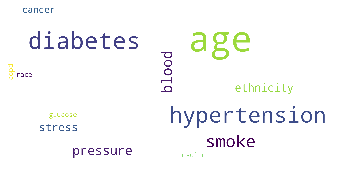

In [426]:
def afficherWordCloud(text):
        wordcloud = WordCloud(background_color='white',
            stopwords=set(stopwords),
            max_words=150,
            max_font_size=42, 
            scale=5).generate(text)
        plt.imshow(wordcloud)
        plt.savefig("word_cloud.png")
        plt.axis("off")
        plt.show()
        
afficherWordCloud(" ".join(tokens_strings_relevant))